In [1]:
from DQN_agent import DQNAgent, RandomAgent
import torch
from classes import DQNNetwork
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from utils import running_average

In [7]:
env = gym.make('LunarLander-v3')
print("env made")
# If you want to render the environment while training run instead:
# env = gym.make('LunarLander-v2', render_mode = "human")
discount_factor = 0.99
env.reset()
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)

q_agent = DQNAgent(n_actions, dim_state, gamma=discount_factor)

env made


In [12]:
# Path to the saved trained weights
trained_weights_path = './weights/neural-network-groundtruth-Gamma0.99-Episodes600.pth'

# Initialize a new instance of the network
trained_network = DQNNetwork(input_size=dim_state, output_size=n_actions, hidden_size=128)

# Load the trained weights into the network
trained_network.load_state_dict(torch.load(trained_weights_path))

# Set the network to evaluation mode
trained_network.eval()

# Replace the agent's network with the trained network
q_agent.network = trained_network

/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_59740/3374152784.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_network.load_state_dict(torch.load(tr

In [14]:
import numpy as np
import torch

def evaluate_q_agent(q_agent, env, n_eval_episodes=50, target_avg_reward=50):
    """
    Evaluate the Q-agent over a specified number of episodes.
    Stops early if the target average reward is achieved.

    Args:
        q_agent (DQNAgent): The trained Q-agent.
        env (gym.Env): The environment to evaluate the agent on.
        n_eval_episodes (int): Number of episodes to evaluate.
        target_avg_reward (float): The target average reward.

    Returns:
        float: The average total reward over the evaluated episodes.
    """
    q_agent.network.eval()  # Set the Q-network to evaluation mode
    rewards = []

    for episode in range(n_eval_episodes):
        state = env.reset()[0]  # Reset the environment
        total_reward = 0
        done, truncated = False, False

        while not (done or truncated):
            # Select an action using the agent's policy
            action = q_agent.forward(state)
            # Step the environment
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state

        rewards.append(total_reward)

        # Compute the average reward so far
        avg_reward = np.mean(rewards)
        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Avg Reward = {avg_reward:.2f}")

        # Early stopping if the target average reward is achieved
        if avg_reward >= target_avg_reward:
            print(f"Target average reward of {target_avg_reward} achieved in {episode + 1} episodes.")
            break

    return avg_reward


# Load the environment
env = gym.make('LunarLander-v3')

# Initialize the Q-agent
q_agent = DQNAgent(
    n_actions=env.action_space.n,
    state_dim=len(env.observation_space.high),
    gamma=0.99,
    lr=1e-3,
    epsilon=0.01,  # Use minimal exploration during evaluation
    epsilon_min=0.01,  # Maintain minimal exploration
    epsilon_decay=1.0,  # No decay during evaluation
    hidden_size=128,
    update_target=10
)

# Load pre-trained weights if available
q_agent.network.load_state_dict(torch.load('./weights/neural-network-groundtruth-Gamma0.99-Episodes600.pth'))

# Evaluate the agent
average_reward = evaluate_q_agent(q_agent, env, n_eval_episodes=50, target_avg_reward=50)

# Print final result
print(f"Final Average Reward over 50 episodes: {average_reward:.2f}")
env.close()

Episode 1: Total Reward = -112.07, Avg Reward = -112.07
Episode 2: Total Reward = 16.84, Avg Reward = -47.61
Episode 3: Total Reward = 20.97, Avg Reward = -24.75
Episode 4: Total Reward = 204.67, Avg Reward = 32.61
Episode 5: Total Reward = 121.28, Avg Reward = 50.34
Target average reward of 50 achieved in 5 episodes.
Final Average Reward over 50 episodes: 50.34


/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_59740/2853067633.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_agent.network.load_state_dict(torch.load('

/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_59740/2610856656.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  state_tensor = torch.tensor([state], dtype=torch.float32)


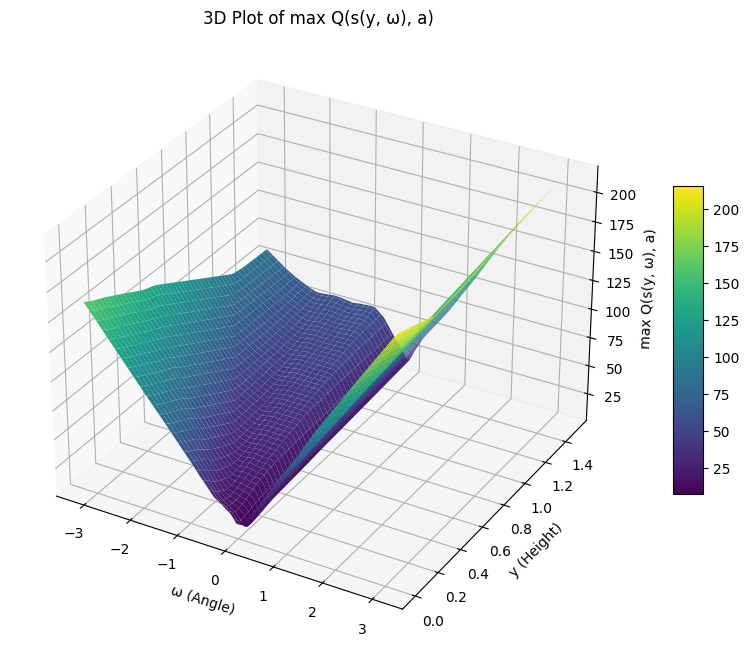

In [9]:
# Set up grid for y and ω
y_vals = np.linspace(0, 1.5, 100)  # Height of the lander
omega_vals = np.linspace(-np.pi, np.pi, 100)  # Angle of the lander
y_grid, omega_grid = np.meshgrid(y_vals, omega_vals)

# Initialize an array to store max Q values
max_q_values = np.zeros_like(y_grid)

# Compute max Q values
for i, y in enumerate(y_vals):
    for j, omega in enumerate(omega_vals):
        # Construct the state vector
        state = np.array([0, y, 0, 0, omega, 0, 0, 0], dtype=np.float32)
        state_tensor = torch.tensor([state], dtype=torch.float32)
        
        # Get Q values for all actions
        with torch.no_grad():
            q_values = q_agent.network(state_tensor).numpy().flatten()
        
        # Store the max Q value
        max_q_values[j, i] = np.max(q_values)

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
surf = ax.plot_surface(omega_grid, y_grid, max_q_values, cmap='viridis')

# Label axes
ax.set_xlabel('ω (Angle)')
ax.set_ylabel('y (Height)')
ax.set_zlabel('max Q(s(y, ω), a)')
ax.set_title('3D Plot of max Q(s(y, ω), a)')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.savefig("./figures/value_function.pdf")
plt.show()

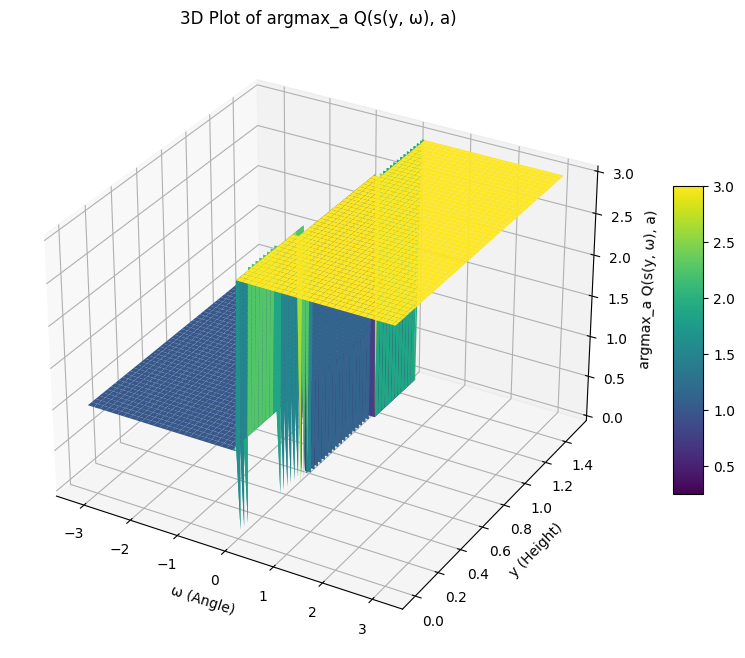

In [10]:
# Set up grid for y and ω
y_vals = np.linspace(0, 1.5, 100)  # Height of the lander
omega_vals = np.linspace(-np.pi, np.pi, 100)  # Angle of the lander
y_grid, omega_grid = np.meshgrid(y_vals, omega_vals)

# Initialize an array to store argmax Q values
argmax_actions = np.zeros_like(y_grid, dtype=int)

# Compute argmax Q values
for i, y in enumerate(y_vals):
    for j, omega in enumerate(omega_vals):
        # Construct the state vector
        state = np.array([0, y, 0, 0, omega, 0, 0, 0], dtype=np.float32)
        state_tensor = torch.tensor([state], dtype=torch.float32)
        
        # Get Q values for all actions
        with torch.no_grad():
            q_values = q_agent.network(state_tensor).numpy().flatten()
        
        # Store the action index that maximizes Q
        argmax_actions[j, i] = np.argmax(q_values)

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
surf = ax.plot_surface(omega_grid, y_grid, argmax_actions, cmap='viridis')

# Label axes
ax.set_xlabel('ω (Angle)')
ax.set_ylabel('y (Height)')
ax.set_zlabel('argmax_a Q(s(y, ω), a)')
ax.set_title('3D Plot of argmax_a Q(s(y, ω), a)')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
fig.savefig("./figures/policy.pdf")
plt.show()

Episode 299 - Reward/Steps: -128.9/110 - Avg. Reward/Steps: -162.1/110: 100%|██████████| 300/300 [00:00<00:00, 320.25it/s]


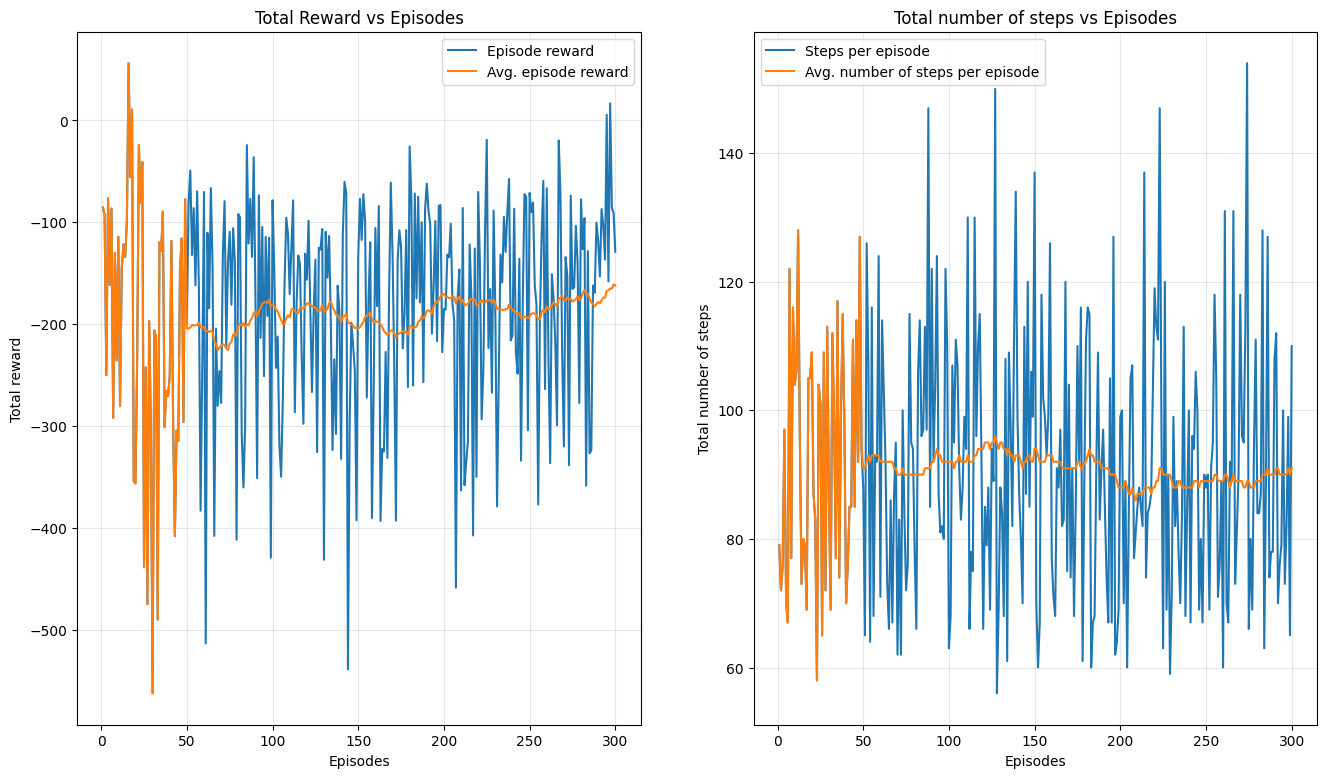

In [6]:
# Random agent initialization
random_agent = RandomAgent(n_actions)
N_episodes = 300
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = [] 
n_ep_running_average = 50      
### Training process
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)

for episode in EPISODES:
    # Reset environment data and initialize variables
    done, truncated = False, False
    state = env.reset()[0]
    total_episode_reward = 0.
    t = 0
    while not (done or truncated):
        # Take a random action
        action = random_agent.forward(state)

        # Get next state and reward
        next_state, reward, done, truncated, _ = env.step(action)

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state
        t += 1

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    avg_reward = running_average(episode_reward_list, n_ep_running_average)[-1]

    # Update progress bar
    EPISODES.set_description(
        f"Episode {episode} - Reward/Steps: {total_episode_reward:.1f}/{t} - Avg. Reward/Steps: {avg_reward:.1f}/{t}")

# Close environment
env.close()

# Plot Rewards and Steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

# Use the length of episode_reward_list for the x-axis
x_range = range(1, len(episode_reward_list) + 1)

ax[0].plot(x_range, episode_reward_list, label='Episode reward')
ax[0].plot(x_range, running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(x_range, episode_number_of_steps, label='Steps per episode')
ax[1].plot(x_range, running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.show()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_plot_agents(q_agent, random_agent, env, n_eval_episodes=50):
    """
    Evaluate and compare the total episodic rewards of a Q-agent and a RandomAgent over multiple episodes,
    and plot the average rewards as a bar chart.

    Args:
        q_agent (DQNAgent): The trained Q-agent.
        random_agent (RandomAgent): The random action agent.
        env (gym.Env): The environment to evaluate the agents on.
        n_eval_episodes (int): Number of episodes to evaluate.

    Returns:
        None: Displays a bar chart comparing the average episodic rewards.
    """
    def evaluate_agent(agent, n_episodes):
        """Evaluate a single agent over multiple episodes."""
        rewards = []
        for _ in range(n_episodes):
            state = env.reset()[0]  # Reset the environment
            total_reward = 0
            done, truncated = False, False
            while not (done or truncated):
                action = agent.forward(state)  # Get action from the agent
                state, reward, done, truncated, _ = env.step(action)  # Step the environment
                total_reward += reward
            rewards.append(total_reward)
        return rewards

    # Set the Q-agent to evaluation mode
    q_agent.network.eval()

    # Evaluate both agents
    print("Evaluating Q-network agent...")
    q_agent_rewards = evaluate_agent(q_agent, n_eval_episodes)
    q_agent_avg_reward = np.mean(q_agent_rewards)

    print("Evaluating Random agent...")
    random_agent_rewards = evaluate_agent(random_agent, n_eval_episodes)
    random_agent_avg_reward = np.mean(random_agent_rewards)

    # Plot average rewards as a bar chart
    agents = ['Q-network Agent', 'Random Agent']
    avg_rewards = [q_agent_avg_reward, random_agent_avg_reward]

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(agents, avg_rewards, color=['blue', 'orange'])

    # Add labels on top of the bars
    for bar, reward in zip(bars, avg_rewards):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position
            bar.get_height() + (5 if reward >= 0 else -15),  # Y position
            f'{reward:.3f}',  # Text
            ha='center', va='bottom' if reward >= 0 else 'top', fontsize=12
        )

    # Add labels and title
    ax.set_ylabel('Average Episodic Reward', fontsize=14)
    ax.set_title('Performance Comparison: Q-network Agent vs. Random Agent', fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print average rewards
    print(f"Average Reward over {n_eval_episodes} Episodes:")
    print(f"Q-network Agent: {q_agent_avg_reward:.2f}")
    print(f"Random Agent: {random_agent_avg_reward:.2f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_agents(q_agent, random_agent, env, n_eval_episodes=50):
    """
    Evaluate and compare the total episodic rewards of a Q-agent and a RandomAgent over multiple episodes.

    Args:
        q_agent (DQNAgent): The trained Q-agent.
        random_agent (RandomAgent): The random action agent.
        env (gym.Env): The environment to evaluate the agents on.
        n_eval_episodes (int): Number of episodes to evaluate.

    Returns:
        None: Displays a plot of the episodic rewards.
    """
    def evaluate_agent(agent, n_episodes):
        """Evaluate a single agent over multiple episodes."""
        rewards = []
        for _ in range(n_episodes):
            state = env.reset()[0]  # Reset the environment
            total_reward = 0
            done, truncated = False, False
            while not (done or truncated):
                action = agent.forward(state)  # Get action from the agent
                state, reward, done, truncated, _ = env.step(action)  # Step the environment
                total_reward += reward
            rewards.append(total_reward)
        return rewards

    # Set the Q-agent to evaluation mode
    q_agent.network.eval()

    # Evaluate both agents
    print("Evaluating Q-network agent...")
    q_agent_rewards = evaluate_agent(q_agent, n_eval_episodes)

    print("Evaluating Random agent...")
    random_agent_rewards = evaluate_agent(random_agent, n_eval_episodes)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(range(1, n_eval_episodes + 1), q_agent_rewards, label="Q-network Agent", marker='o')
    plt.plot(range(1, n_eval_episodes + 1), random_agent_rewards, label="Random Agent", marker='x')

    plt.xlabel('Episode')
    plt.ylabel('Total Episodic Reward')
    plt.title('Comparison of Q-network Agent and Random Agent')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Print average rewards
    print(f"Average Reward over {n_eval_episodes} Episodes:")
    print(f"Q-network Agent: {np.mean(q_agent_rewards):.2f}")
    print(f"Random Agent: {np.mean(random_agent_rewards):.2f}")

In [19]:
# Load the environment
env = gym.make('LunarLander-v3')

# Initialize the Q-agent
q_agent = DQNAgent(
    n_actions=env.action_space.n,
    state_dim=len(env.observation_space.high),
    gamma=0.99,
    lr=1e-3,
    epsilon=0.01,
    epsilon_min=0.01,
    epsilon_decay=1.0,
    hidden_size=128,
    update_target=10
)

# Load pre-trained weights
q_agent.network.load_state_dict(torch.load('./weights/neural-network-groundtruth-Gamma0.99-Episodes600.pth'))

# Initialize the RandomAgent
random_agent = RandomAgent(n_actions=env.action_space.n)

/var/folders/ry/91_grybj6vq_5712z9pmyw840000gn/T/ipykernel_59740/4030816361.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_agent.network.load_state_dict(torch.load('

Evaluating Q-network agent...
Evaluating Random agent...


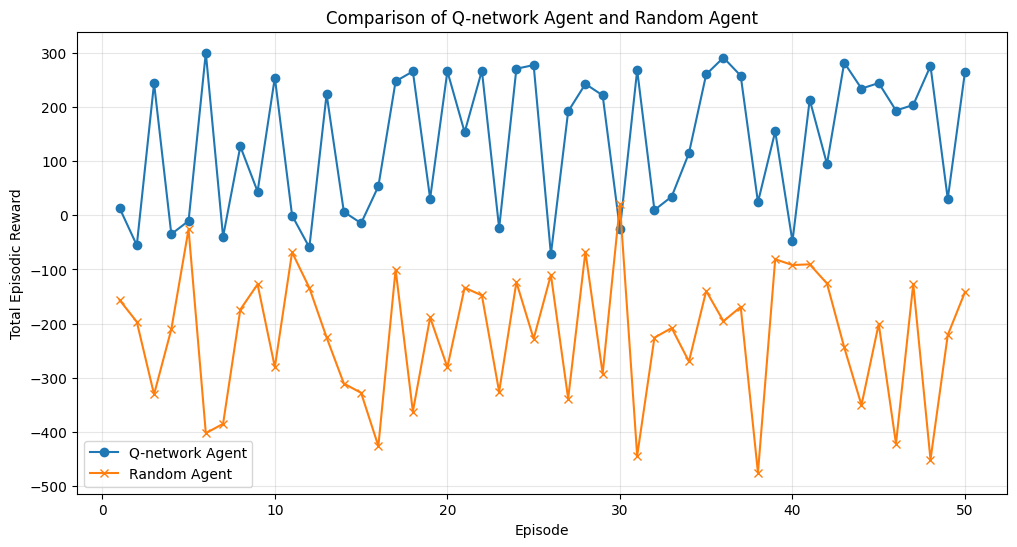

Average Reward over 50 Episodes:
Q-network Agent: 135.36
Random Agent: -222.63


In [20]:
evaluate_agents(q_agent, random_agent, env, n_eval_episodes=50)

Evaluating Q-network agent...
Evaluating Random agent...


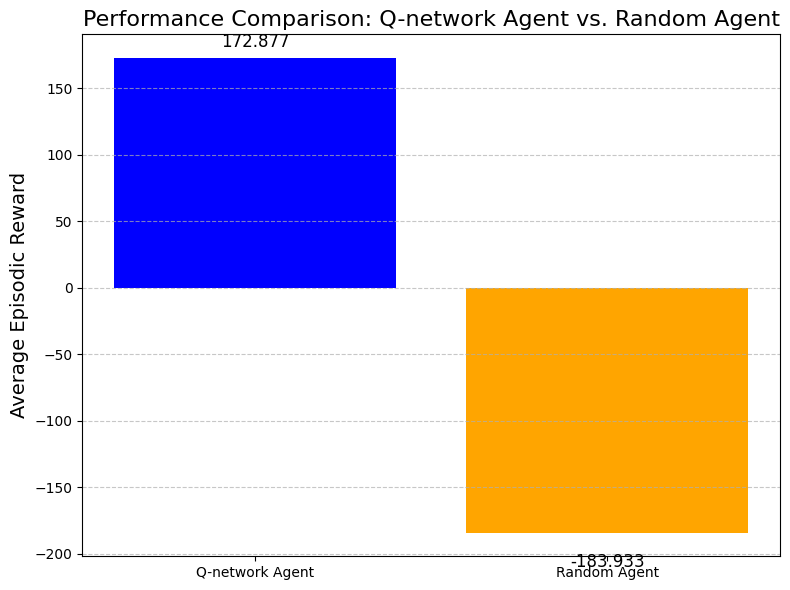

Average Reward over 50 Episodes:
Q-network Agent: 172.88
Random Agent: -183.93


In [23]:
# Assume env, q_agent, and random_agent are already initialized
evaluate_and_plot_agents(q_agent, random_agent, env, n_eval_episodes=50)